
Results for TANH activation function

Width   Depth 3                   Depth 5                   Depth 9                   
--------------------------------------------------------------------
5       0.045/0.052        0.040/0.056        0.031/0.040        
10      0.050/0.080        0.019/0.022        0.013/0.018        
25      0.029/0.028        0.002/0.002        0.010/0.014        
50      0.003/0.008        0.003/0.008        0.017/0.016        
100     0.001/0.002        0.010/0.010        0.054/0.064        

Format: Training Error / Test Error

Results for RELU activation function

Width   Depth 3                   Depth 5                   Depth 9                   
--------------------------------------------------------------------
5       0.358/0.394        0.393/0.394        0.249/0.252        
10      0.085/0.094        0.042/0.034        0.039/0.044        
25      0.002/0.004        0.026/0.030        0.008/0.006        
50      0.001/0.004        0.025/0.036       

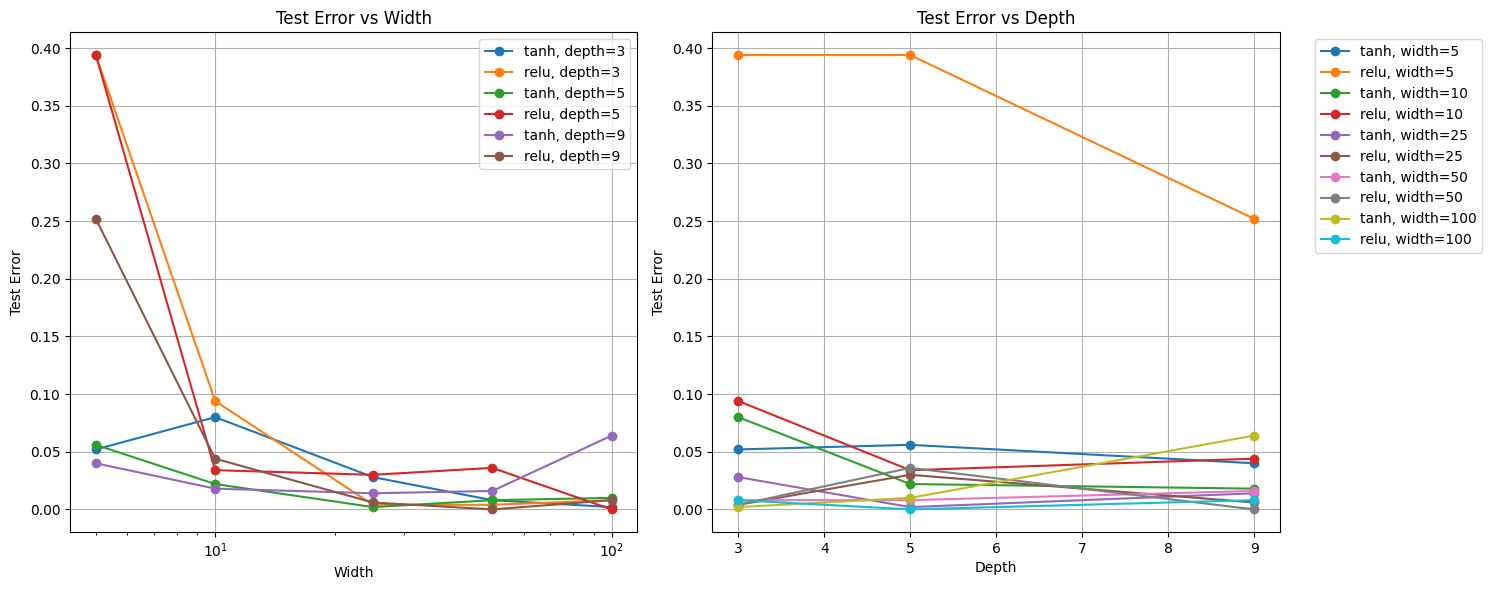

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

class BankNoteNet(nn.Module):
    def __init__(self, input_size, hidden_size, depth, activation='tanh'):
        super(BankNoteNet, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Hidden layers
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            
        # Output layer
        self.layers.append(nn.Linear(hidden_size, 1))
        
        # Set activation function
        self.activation = nn.Tanh() if activation == 'tanh' else nn.ReLU()
        
        # Initialize weights based on activation function
        self._initialize_weights(activation)
        
    def _initialize_weights(self, activation):
        for layer in self.layers[:-1]:  # All except last layer
            if activation == 'tanh':
                # Xavier initialization
                nn.init.xavier_uniform_(layer.weight)
            else:
                # He initialization
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)
            
        # Initialize output layer with small random values
        nn.init.xavier_uniform_(self.layers[-1].weight)
        nn.init.zeros_(self.layers[-1].bias)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = torch.sigmoid(self.layers[-1](x))  # Sigmoid for binary classification
        return x

def load_data(train_path, test_path):
    """Load and prepare the bank-note dataset"""
    train_data = pd.read_csv(train_path, header=None)
    test_data = pd.read_csv(test_path, header=None)
    
    X_train = torch.FloatTensor(train_data.iloc[:, :-1].values)
    y_train = torch.FloatTensor(train_data.iloc[:, -1].values)
    X_test = torch.FloatTensor(test_data.iloc[:, :-1].values)
    y_test = torch.FloatTensor(test_data.iloc[:, -1].values)
    
    return X_train, y_train, X_test, y_test

def train_model(model, X_train, y_train, X_test, y_test, max_updates=500):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    indices = torch.randperm(X_train.shape[0])
    i = 0
    
    for update in range(max_updates):
        if i >= X_train.shape[0]:
            indices = torch.randperm(X_train.shape[0])
            i = 0
            
        idx = indices[i]
        X = X_train[idx:idx+1]
        y = y_train[idx:idx+1]
        
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.reshape(-1, 1))
        loss.backward()
        optimizer.step()
        
        i += 1
    
    # Compute final errors
    model.eval()
    with torch.no_grad():
        train_pred = (model(X_train) > 0.5).float()
        test_pred = (model(X_test) > 0.5).float()
        
        train_error = 1 - (train_pred == y_train.reshape(-1, 1)).float().mean()
        test_error = 1 - (test_pred == y_test.reshape(-1, 1)).float().mean()
    
    return train_error.item(), test_error.item()

def main():
    X_train, y_train, X_test, y_test = load_data("train.csv", "test.csv")
    input_size = X_train.shape[1]
    
    depths = [3, 5, 9]
    widths = [5, 10, 25, 50, 100]
    activations = ['tanh', 'relu']
    
    # Store results
    all_results = []
    
    for activation in activations:
        print(f"\n{'='*80}")
        print(f"Results for {activation.upper()} activation function")
        print(f"{'='*80}")
        
        # Create table header
        print(f"\n{'Width':<8}", end='')
        for depth in depths:
            print(f"Depth {depth:<20}", end='')
        print()
        print("-" * 68)
        
        # For each width, show results across all depths
        for width in widths:
            print(f"{width:<8}", end='')
            
            for depth in depths:
                model = BankNoteNet(input_size, width, depth, activation)
                train_error, test_error = train_model(model, X_train, y_train, X_test, y_test)
                
                print(f"{train_error:.3f}/{test_error:.3f}{'':8}", end='')
                
                all_results.append({
                    'activation': activation,
                    'depth': depth,
                    'width': width,
                    'train_error': train_error,
                    'test_error': test_error
                })
            print()  # New line after each width
        
        print("\nFormat: Training Error / Test Error")
    
    # Plot results
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    for depth in depths:
        for activation in activations:
            results = [(r['width'], r['test_error']) for r in all_results 
                      if r['depth'] == depth and r['activation'] == activation]
            widths_plot, errors_plot = zip(*results)
            plt.plot(widths_plot, errors_plot, marker='o', 
                    label=f'{activation}, depth={depth}')
    
    plt.xscale('log')
    plt.xlabel('Width')
    plt.ylabel('Test Error')
    plt.title('Test Error vs Width')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for width in widths:
        for activation in activations:
            results = [(r['depth'], r['test_error']) for r in all_results 
                      if r['width'] == width and r['activation'] == activation]
            depths_plot, errors_plot = zip(*results)
            plt.plot(depths_plot, errors_plot, marker='o', 
                    label=f'{activation}, width={width}')
    
    plt.xlabel('Depth')
    plt.ylabel('Test Error')
    plt.title('Test Error vs Depth')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()